In [1]:
import pandas as pd
import numpy as np
import joblib
import py3dotplus
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.tree import DecisionTreeClassifier,export_graphviz,export_text
from sklearn.metrics import classification_report,roc_auc_score
from sklearn.model_selection import train_test_split, GridSearchCV, cross_validate,validation_curve
from skompiler import skompile
df = pd.read_csv("diabetes.csv")
df.head()


,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,148,72,35,0,33.6,0.627,50,1
1,1,85,66,29,0,26.6,0.351,31,0
2,8,183,64,0,0,23.3,0.672,32,1
3,1,89,66,23,94,28.1,0.167,21,0
4,0,137,40,35,168,43.1,2.288,33,1


In [2]:
def outliers(df,variable):
    q1= df[variable].quantile(0.10)
    q3 = df[variable].quantile(0.90)
    iqr = q3 - q1
    lower_lim = q1 - 1.5*iqr
    upper_lim = q3 + 1.5*iqr
    return lower_lim,upper_lim

def check_outliers(df,variable):
    lower_lim,upper_lim = outliers(df,variable)
    if df.loc[(df[variable]<lower_lim) | (df[variable]>upper_lim)].any(axis=None):
        return True
    else:
        return False
    
def replace_outliers(df,variable):
    lower_lim, upper_lim = outliers(df,variable)
    df[variable].clip(lower=lower_lim, upper=upper_lim,inplace=True)
    
df["Glucose"] =df["Glucose"].replace(0,np.nan)
df["BloodPressure"] = df["BloodPressure"].replace(0,np.nan)
df["SkinThickness"] = df["SkinThickness"].replace(0,np.nan)
df["Insulin"] = df["Insulin"].replace(0,np.nan)
df["BMI"] = df["BMI"].replace(0,np.nan)
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import Ridge
from xgboost import XGBRegressor
imp= IterativeImputer(
    estimator=XGBRegressor(n_estimators=300,max_depth=7),
    max_iter=30,
    random_state=0
).set_output(transform="pandas")

df2=imp.fit_transform(df)

c:\Users\oskar\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\impute\_iterative.py:796: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  warnings.warn(


In [3]:
X = df2.drop("Outcome",axis=1)
y=df2["Outcome"]
replace_outliers(df2,"SkinThickness")
replace_outliers(df2,"Insulin")
for col in list(X.keys()):
    print(col,check_outliers(df2,col))

Pregnancies False
Glucose False
BloodPressure False
SkinThickness False
Insulin False
BMI False
DiabetesPedigreeFunction True
Age False


In [4]:
clf = DecisionTreeClassifier()

In [5]:
clf.fit(X,y)
y_pred=clf.predict(X)
print(classification_report(y,y_pred)) # overfit

              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00       500
         1.0       1.00      1.00      1.00       268

    accuracy                           1.00       768
   macro avg       1.00      1.00      1.00       768
weighted avg       1.00      1.00      1.00       768



In [6]:
from sklearn.model_selection import cross_validate
cv_results= cross_validate(clf,X,y,cv=10,scoring=["accuracy","precision","recall","f1","roc_auc"])
cv_results

{'fit_time': array([0.00840831, 0.00760818, 0.00822568, 0.00684094, 0.00647306,
        0.00788975, 0.0087359 , 0.00752902, 0.00735521, 0.00797963]),
 'score_time': array([0.01238394, 0.01190543, 0.00873208, 0.00905728, 0.00900745,
        0.00876069, 0.00940394, 0.00868416, 0.00829816, 0.00797868]),
 'test_accuracy': array([0.71428571, 0.64935065, 0.62337662, 0.67532468, 0.75324675,
        0.7012987 , 0.77922078, 0.77922078, 0.67105263, 0.72368421]),
 'test_precision': array([0.6       , 0.5       , 0.46666667, 0.53846154, 0.72222222,
        0.56666667, 0.70833333, 0.70833333, 0.51724138, 0.59259259]),
 'test_recall': array([0.55555556, 0.48148148, 0.51851852, 0.51851852, 0.48148148,
        0.62962963, 0.62962963, 0.62962963, 0.57692308, 0.61538462]),
 'test_f1': array([0.57692308, 0.49056604, 0.49122807, 0.52830189, 0.57777778,
        0.59649123, 0.66666667, 0.66666667, 0.54545455, 0.60377358]),
 'test_roc_auc': array([0.67777778, 0.61074074, 0.59925926, 0.63925926, 0.69074074,
 

In [7]:
cv_results["test_precision"].mean()

0.5798404304878166

In [8]:
cv_results["test_accuracy"].mean()

0.7030758714969242

In [9]:
cv_results["test_roc_auc"].mean()

0.6776524216524217

In [10]:
clf.get_params()

{'ccp_alpha': 0.0,
 'class_weight': None,
 'criterion': 'gini',
 'max_depth': None,
 'max_features': None,
 'max_leaf_nodes': None,
 'min_impurity_decrease': 0.0,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'random_state': None,
 'splitter': 'best'}

In [12]:
param_grid = {"max_depth":[3,4,5,6,7,8],
              "min_samples_leaf":range(2,20),
              "min_samples_split":range(2,20)}
gs = GridSearchCV(clf,param_grid=param_grid,cv=10,n_jobs=-1,scoring="roc_auc")
gs.fit(X,y)

GridSearchCV(cv=10, estimator=DecisionTreeClassifier(), n_jobs=-1,
             param_grid={'max_depth': [3, 4, 5, 6, 7, 8],
                         'min_samples_leaf': range(2, 20),
                         'min_samples_split': range(2, 20)},
             scoring='roc_auc')

In [13]:
gs.best_params_

{'max_depth': 5, 'min_samples_leaf': 19, 'min_samples_split': 8}

In [15]:
clf2 = DecisionTreeClassifier(**gs.best_params_)
cv_results= cross_validate(clf2,X,y,cv=10,scoring=["accuracy","precision","recall","f1","roc_auc"])
cv_results["test_precision"].mean()

0.6514282344892959

In [16]:
cv_results["test_accuracy"].mean()

0.744771018455229

In [17]:
cv_results["test_roc_auc"].mean()

0.8067820512820513

In [11]:
from sklearn.ensemble import RandomForestClassifier
rf = RandomForestClassifier()
rf.get_params()

{'bootstrap': True,
 'ccp_alpha': 0.0,
 'class_weight': None,
 'criterion': 'gini',
 'max_depth': None,
 'max_features': 'sqrt',
 'max_leaf_nodes': None,
 'max_samples': None,
 'min_impurity_decrease': 0.0,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 100,
 'n_jobs': None,
 'oob_score': False,
 'random_state': None,
 'verbose': 0,
 'warm_start': False}

In [18]:
param_grid = {"max_depth":[3,4,5,6,7,8],
              "min_samples_leaf":range(2,20),
              "min_samples_split":range(2,20),
              "n_estimators":[100,200,300]}
rf = RandomForestClassifier()
gs = GridSearchCV(rf,param_grid=param_grid,cv=10,n_jobs=-1,scoring="roc_auc")
gs.fit(X,y)

GridSearchCV(cv=10, estimator=RandomForestClassifier(), n_jobs=-1,
             param_grid={'max_depth': [3, 4, 5, 6, 7, 8],
                         'min_samples_leaf': range(2, 20),
                         'min_samples_split': range(2, 20),
                         'n_estimators': [100, 200, 300]},
             scoring='roc_auc')

In [19]:
gs.best_params_

{'max_depth': 8,
 'min_samples_leaf': 4,
 'min_samples_split': 9,
 'n_estimators': 300}

In [24]:
rf = RandomForestClassifier(**gs.best_params_)
cv_results= cross_validate(rf,X,y,cv=10,scoring=["accuracy","precision","recall","f1","roc_auc"])
cv_results["test_precision"].mean()

0.6932216643006116

In [22]:
cv_results["test_accuracy"].mean()

0.7681818181818182

In [28]:
cv_results["test_roc_auc"].mean()

0.8415555555555555

In [29]:
rf = RandomForestClassifier()
rf.get_params()

{'bootstrap': True,
 'ccp_alpha': 0.0,
 'class_weight': None,
 'criterion': 'gini',
 'max_depth': None,
 'max_features': 'sqrt',
 'max_leaf_nodes': None,
 'max_samples': None,
 'min_impurity_decrease': 0.0,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 100,
 'n_jobs': None,
 'oob_score': False,
 'random_state': None,
 'verbose': 0,
 'warm_start': False}

In [30]:
rf.set_params(**gs.best_params_)

RandomForestClassifier(max_depth=8, min_samples_leaf=4, min_samples_split=9,
                       n_estimators=300)

In [31]:
rf.get_params()

{'bootstrap': True,
 'ccp_alpha': 0.0,
 'class_weight': None,
 'criterion': 'gini',
 'max_depth': 8,
 'max_features': 'sqrt',
 'max_leaf_nodes': None,
 'max_samples': None,
 'min_impurity_decrease': 0.0,
 'min_samples_leaf': 4,
 'min_samples_split': 9,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 300,
 'n_jobs': None,
 'oob_score': False,
 'random_state': None,
 'verbose': 0,
 'warm_start': False}

In [34]:
clf = DecisionTreeClassifier(max_depth= 5, min_samples_leaf= 19, min_samples_split= 8)

In [35]:
clf.fit(X,y)

DecisionTreeClassifier(max_depth=5, min_samples_leaf=19, min_samples_split=8)

In [40]:
pd.Series(clf.feature_importances_,index = list(X.columns)).sort_values(ascending=False)

Glucose                     0.504072
BMI                         0.167485
Age                         0.101188
Insulin                     0.100628
DiabetesPedigreeFunction    0.087230
SkinThickness               0.020751
BloodPressure               0.018646
Pregnancies                 0.000000
dtype: float64

In [42]:
rf.fit(X,y)
pd.Series(rf.feature_importances_,index = list(X.columns)).sort_values(ascending=False)

Glucose                     0.274690
Insulin                     0.191243
BMI                         0.133885
Age                         0.131519
DiabetesPedigreeFunction    0.085973
SkinThickness               0.080207
Pregnancies                 0.056878
BloodPressure               0.045605
dtype: float64

<Axes: >

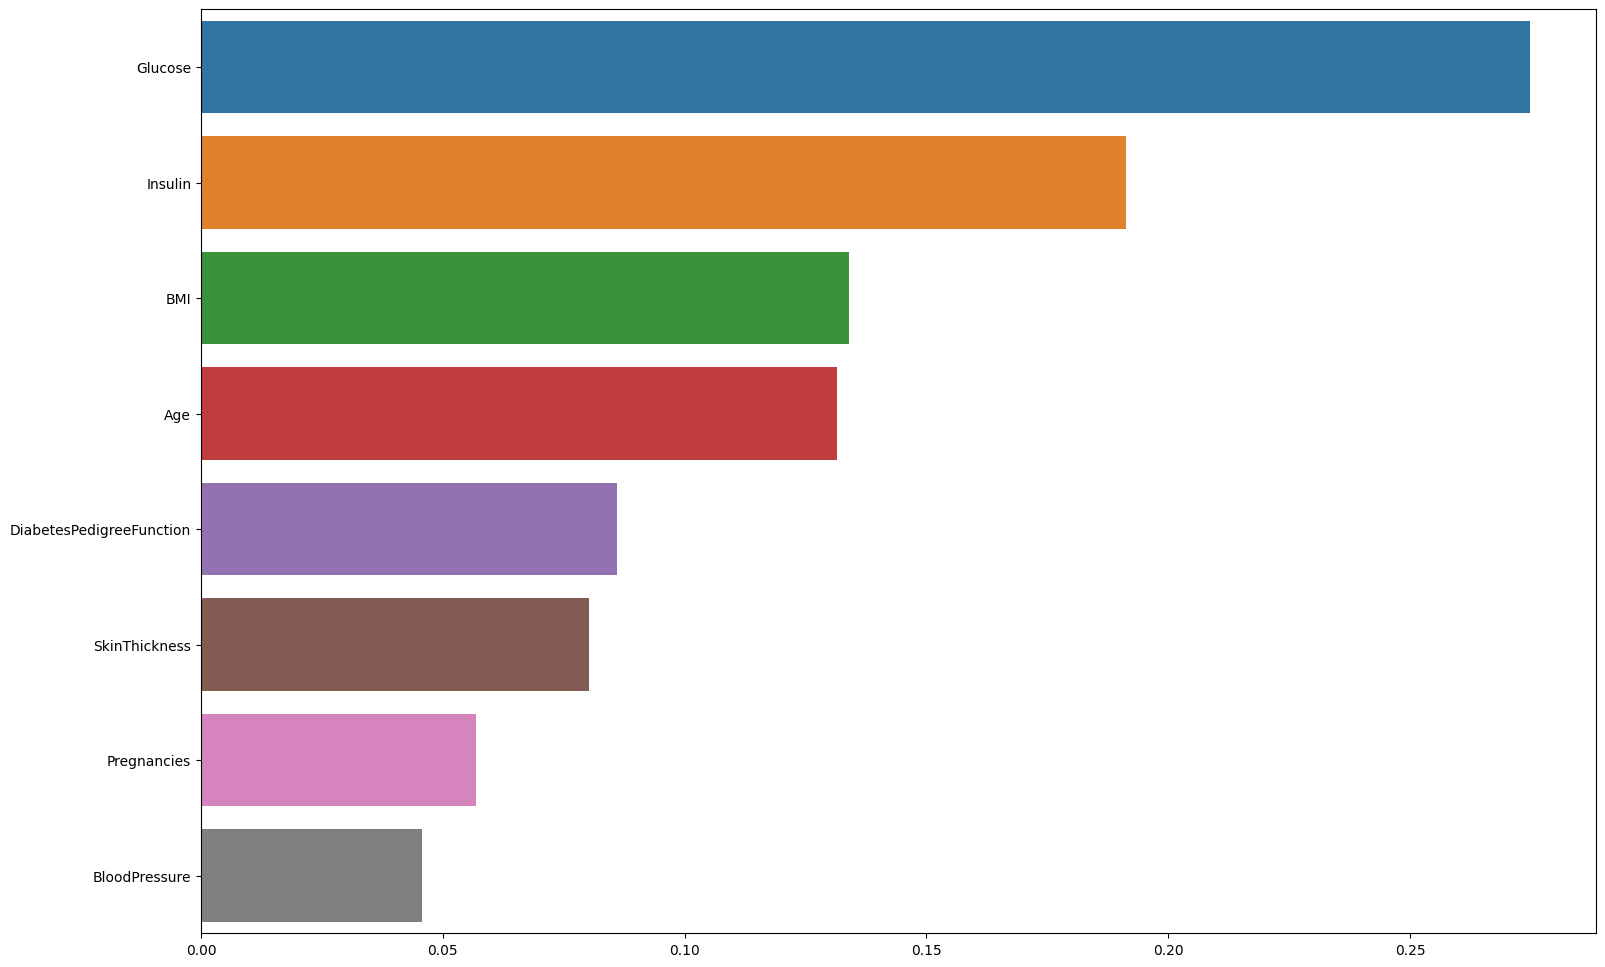

In [51]:
a=pd.Series(rf.feature_importances_,index = list(X.columns)).sort_values(ascending=False)
plt.figure(figsize=(18,12))
sns.barplot(y=a.index,x=a.values)

<Axes: >

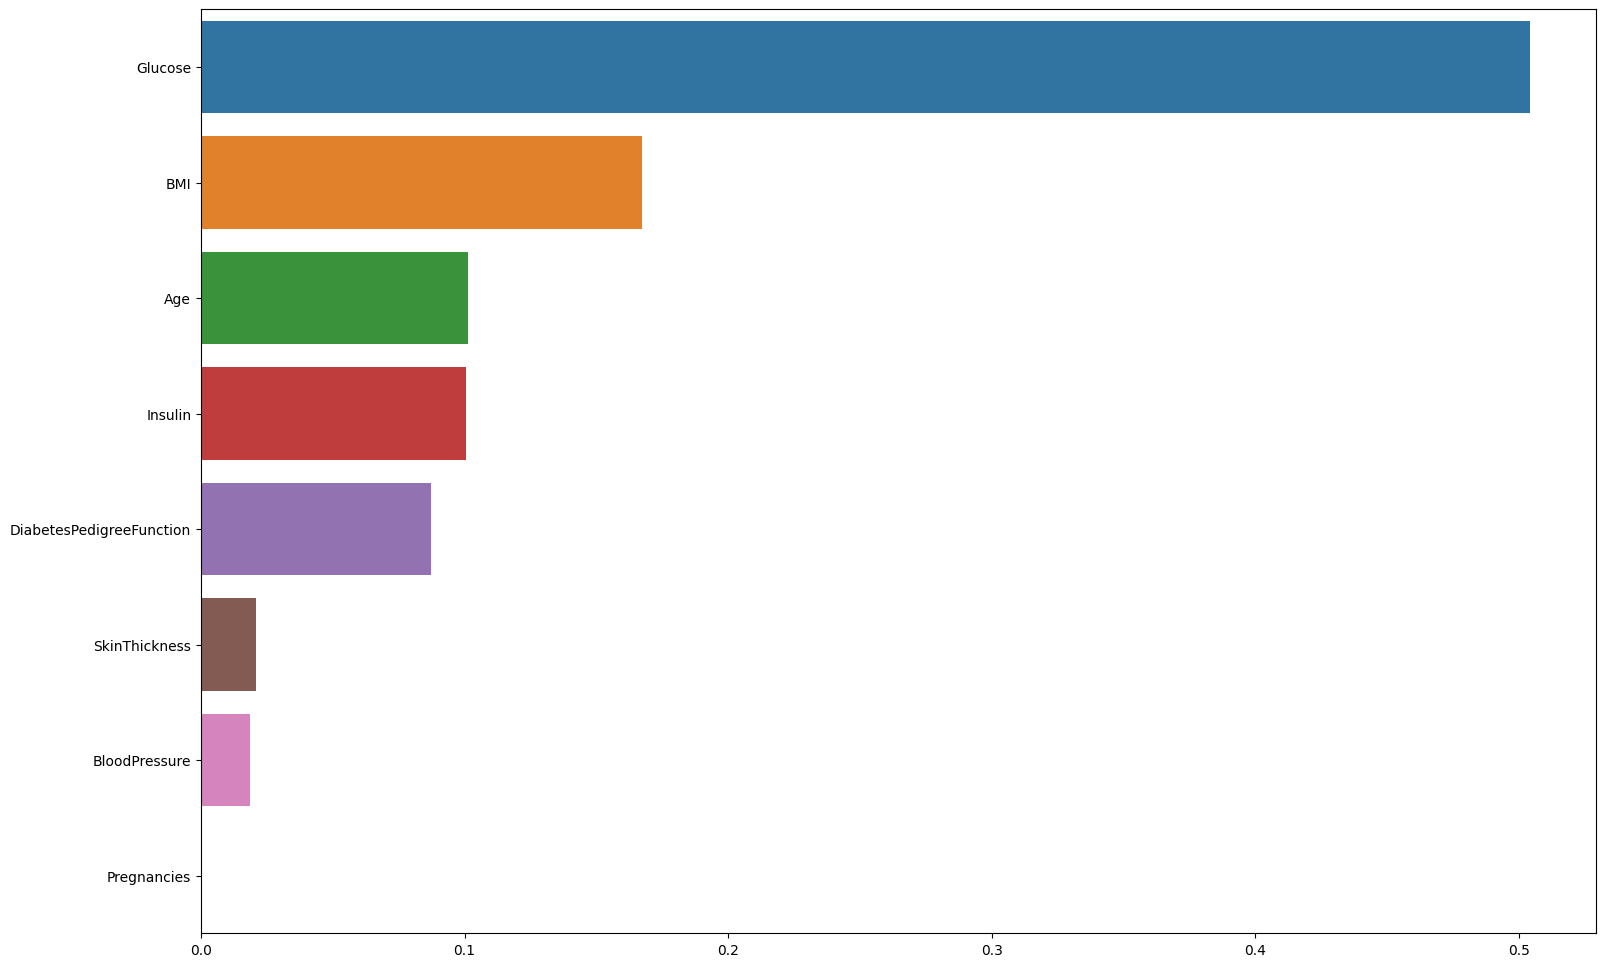

In [52]:
b=pd.Series(clf.feature_importances_,index = list(X.columns)).sort_values(ascending=False)
plt.figure(figsize=(18,12))
sns.barplot(y=b.index,x=b.values)

In [70]:
def plot_imp(model, features, num=None, save=False):
    if num is None:
        num = len(features)
    
    feature_imp = pd.DataFrame({"Value":model.feature_importances_, "Feature":list(features.columns)})
    feature_imp = feature_imp.sort_values(by="Value", ascending=False).iloc[:num]
    
    plt.figure(figsize=(10,10))
    sns.set(font_scale=1)
    sns.barplot(x="Value", y="Feature", data=feature_imp)
    
    plt.title("Features")
    plt.tight_layout()
    plt.show()
    
    if save:
        plt.savefig(f"{model}.importances.png")

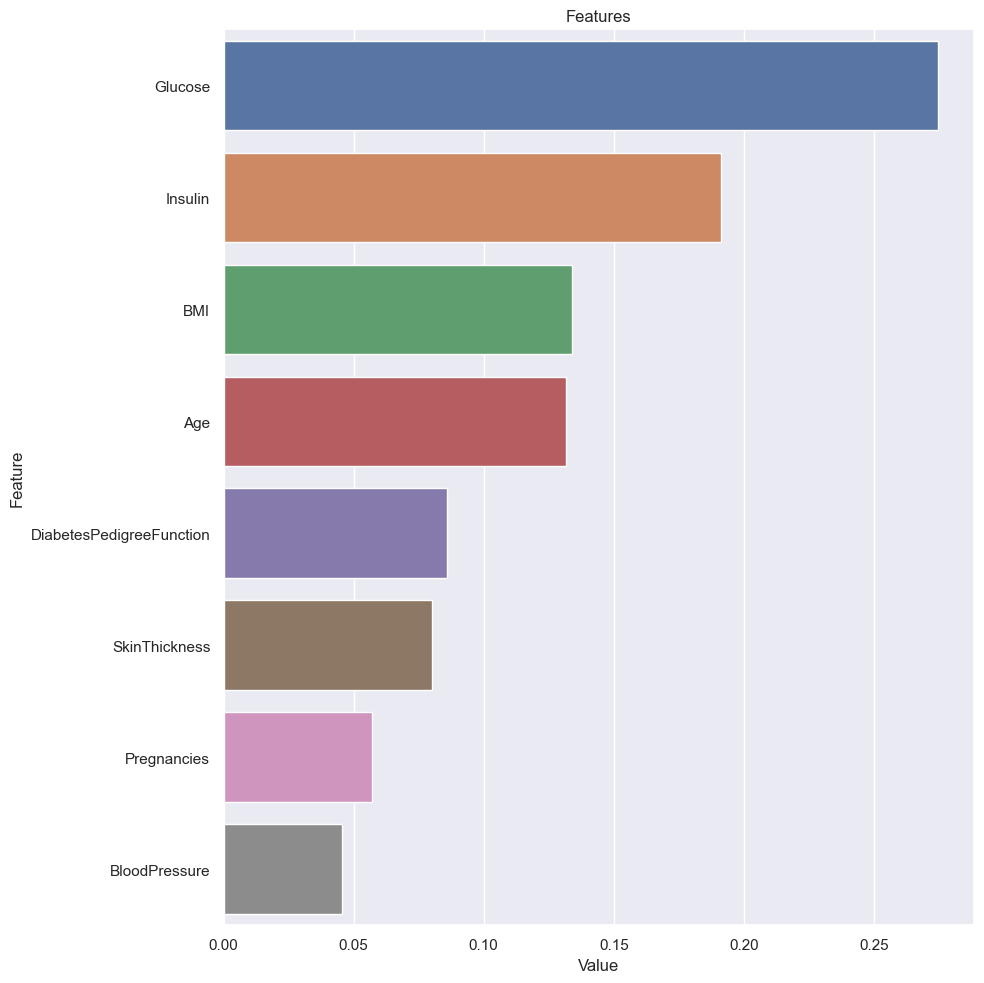

In [71]:
plot_imp(model=rf,features=X)

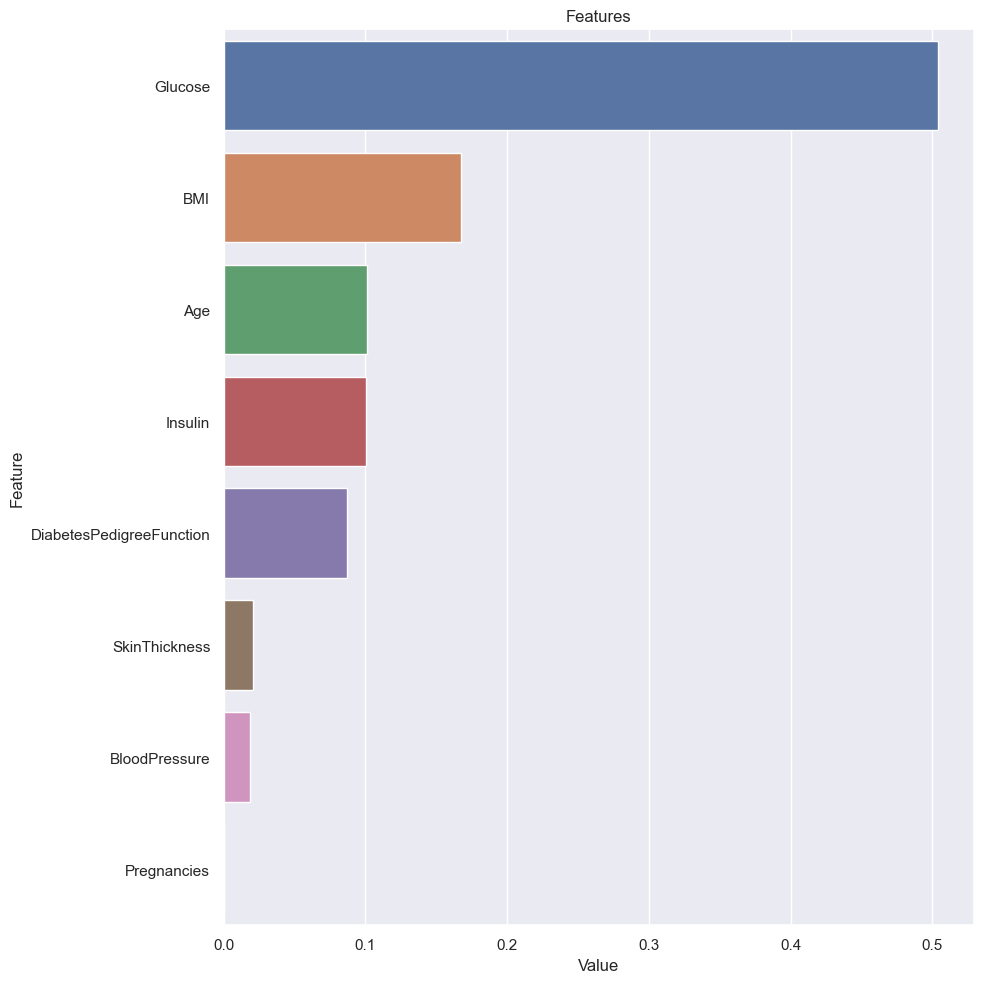

In [72]:
plot_imp(model=clf,features=X)

In [87]:
train_score, test_score = validation_curve(clf,X,y,
                                           param_name="max_depth",
                                           param_range=range(2,5),
                                           scoring="roc_auc",
                                           cv=10)

In [88]:
pd.DataFrame(test_score)

,0,1,2,3,4,5,6,7,8,9
0,0.755926,0.725926,0.785185,0.691481,0.610370,0.764074,0.771481,0.813333,0.711538,0.786923
1,0.775926,0.745556,0.819259,0.723333,0.723704,0.817037,0.814444,0.834444,0.740000,0.830000
2,0.769259,0.775185,0.818519,0.721111,0.721852,0.853704,0.831852,0.855556,0.767692,0.826923


In [106]:
clf3 = DecisionTreeClassifier()

In [111]:
train_score, test_score = validation_curve(clf3,X,y,
                                           param_name="max_depth",
                                           param_range=range(1,15),
                                           scoring="roc_auc",
                                           cv=10)

In [112]:
mean_train_score = np.mean(train_score,axis=1)
mean_test_score = np.mean(test_score,axis=1)

In [113]:
mean_test_score

array([0.67445584, 0.73832764, 0.76452707, 0.76534046, 0.75560826,
       0.73206553, 0.71838746, 0.69180342, 0.70110826, 0.67115812,
       0.68461538, 0.69169516, 0.67916524, 0.67601994])

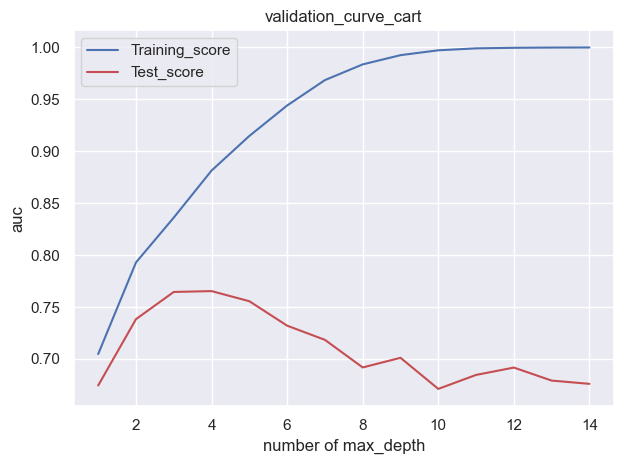

In [114]:
plt.plot(range(1,15),mean_train_score,
         label = "Training_score",color="b")

plt.plot(range(1,15),mean_test_score,
         label = "Test_score",color="r")
plt.title("validation_curve_cart")
plt.xlabel("number of max_depth")
plt.ylabel("auc")
plt.tight_layout()
plt.legend(loc="best")
plt.show()

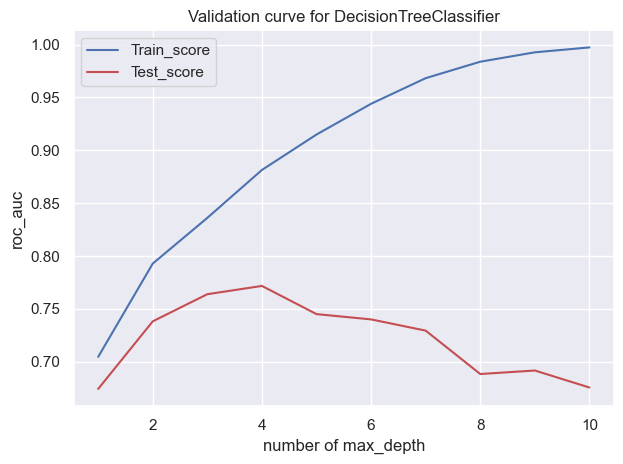

In [127]:
def val_curve(model,X,y,param_name,param_range,scoring="roc_auc",cv=10):
    train_score, test_score= validation_curve(model,X,y,param_name=param_name,
                                              param_range=param_range,
                                              scoring=scoring,cv=cv)
    
    mean_train_score = np.mean(train_score,axis=1)
    mean_test_score = np.mean(test_score,axis=1)
    plt.plot(param_range,mean_train_score,label="Train_score",color="b")
    plt.plot(param_range,mean_test_score,label="Test_score",color="r")
    plt.title(f"Validation curve for {type(model).__name__}")
    plt.xlabel(f"number of {param_name}")
    plt.ylabel(f"{scoring}")
    plt.tight_layout()
    plt.legend(loc="best")
    plt.show(block=True)
val_curve(clf3,X,y,"max_depth",param_range=range(1,11))

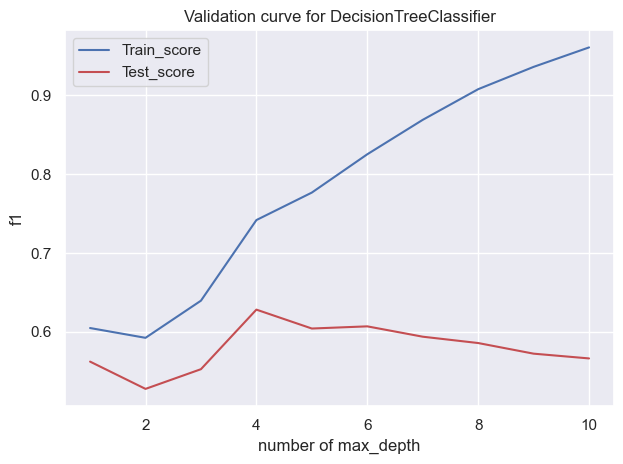

In [122]:
val_curve(clf3,X,y,"max_depth",param_range=range(1,11),scoring="f1")

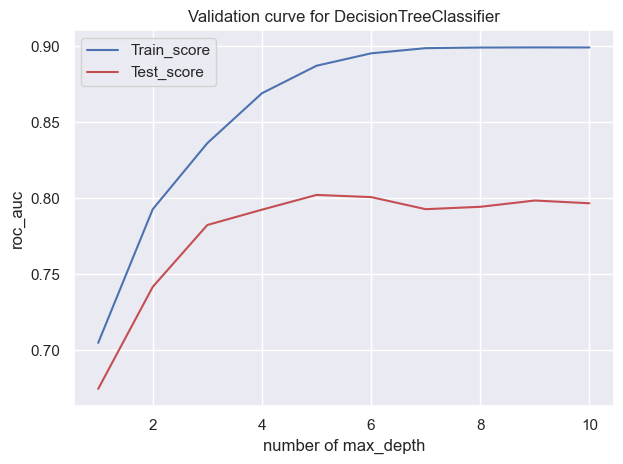

In [121]:
val_curve(clf,X,y,"max_depth",param_range=range(1,11))

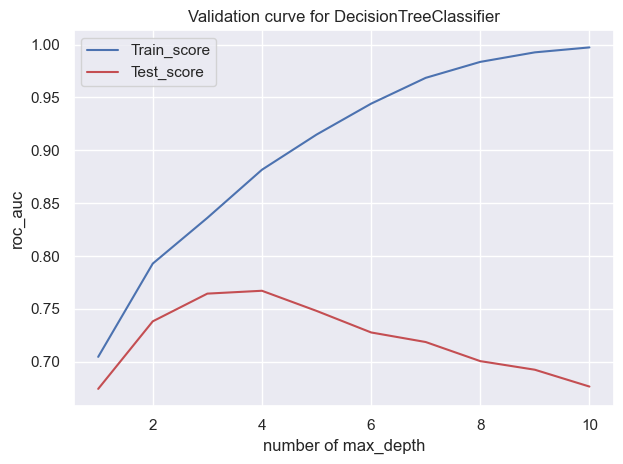

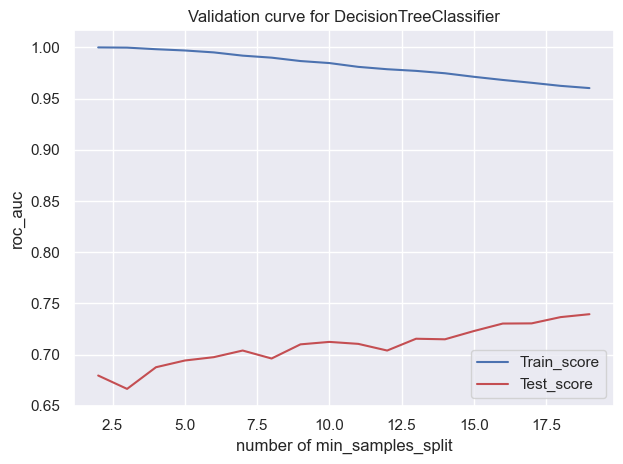

In [138]:
cart_val_params = [["max_depth",range(1,11)],["min_samples_split",range(2,20)]]
for i in range(len(cart_val_params)):
    val_curve(clf3,X,y,cart_val_params[i][0],cart_val_params[i][1])

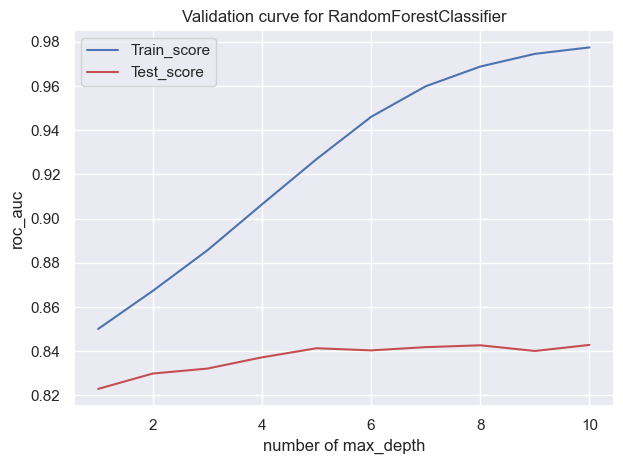

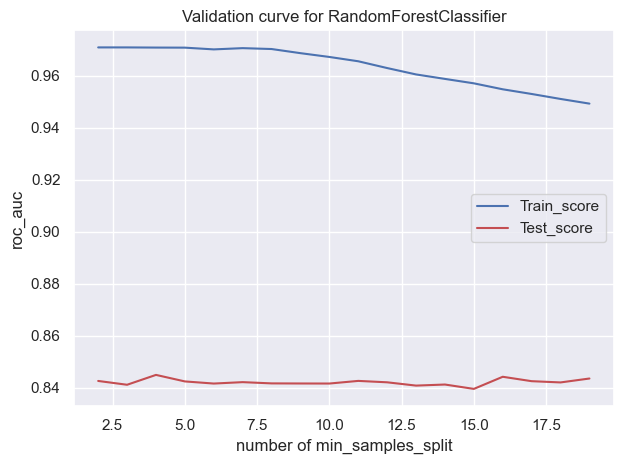

In [140]:
cart_val_params = [["max_depth",range(1,11)],["min_samples_split",range(2,20)]]
for i in range(len(cart_val_params)):
    val_curve(rf,X,y,cart_val_params[i][0],cart_val_params[i][1])

In [30]:
clf2= DecisionTreeClassifier(max_depth= 5, min_samples_leaf= 19, min_samples_split= 8)
clf2.fit(X,y)

DecisionTreeClassifier(max_depth=5, min_samples_leaf=19, min_samples_split=8)

In [31]:
import sklearn
sklearn.__version__

'1.3.0'

In [34]:
expression = skompile(clf2.predict)
print(expression.to("python/code"))

(((((0 if x[1] <= 118.0 else 0) if x[3] <= 28.706296920776367 else 0 if x[6
    ] <= 0.4739999920129776 else 0) if x[6] <= 0.8229999840259552 else 0) if
    x[4] <= 121.94884872436523 else (0 if x[3] <= 31.130478858947754 else 0
    ) if x[7] <= 28.5 else 0 if x[5] <= 27.050000190734863 else 1 if x[6] <=
    0.6235000193119049 else 1) if x[1] <= 127.5 else ((0 if x[1] <= 134.5 else
    0) if x[1] <= 145.5 else 1) if x[5] <= 29.949999809265137 else ((1 if x
    [2] <= 73.87578964233398 else 0) if x[7] <= 30.5 else 1 if x[6] <= 
    0.4294999986886978 else 1) if x[1] <= 154.5 else 1 if x[6] <= 
    0.3004999905824661 else 1 if x[4] <= 340.2620391845703 else 1)



In [ ]:
expr = skompile(clf2.predict)
sql = expr.to('sqlalchemy/sqlite')

In [ ]:
from skompiler import skompile
X = df.drop("Outcome",axis=1)
y = df["Outcome"]
clf2 = DecisionTreeClassifier()
clf2.fit(X,y)
sql_expr = skompile(clf2.predict).to('sqlalchemy/sqlite')
print(sql_expr)

In [45]:
skompile(clf2.predict).to("excel")

ExcelCode([('A1',
            'IF((x2<=127.5),IF((x5<=121.94884872436523),0,IF((x8<=28.5),0,IF((x6<=27.050000190734863),0,1))),IF((x6<=29.949999809265137),IF((x2<=145.5),0,1),IF((x2<=154.5),IF((x8<=30.5),IF((x3<=73.87578964233398),1,0),1),1)))')])

In [52]:
def predict_with_rules(x):
    return (((((0 if x[1] <= 118.0 else 0) if x[3] <= 28.706296920776367 else 0 if x[6
    ] <= 0.4739999920129776 else 0) if x[6] <= 0.8229999840259552 else 0) if
    x[4] <= 121.94884872436523 else (0 if x[3] <= 31.130478858947754 else 0
    ) if x[7] <= 28.5 else 0 if x[5] <= 27.050000190734863 else 1 if x[6] <=
    0.6235000193119049 else 1) if x[1] <= 127.5 else ((0 if x[1] <= 134.5 else
    0) if x[1] <= 145.5 else 1) if x[5] <= 29.949999809265137 else ((1 if x
    [2] <= 73.87578964233398 else 0) if x[7] <= 30.5 else 1 if x[6] <= 
    0.4294999986886978 else 1) if x[1] <= 154.5 else 1 if x[6] <= 
    0.3004999905824661 else 1 if x[4] <= 340.2620391845703 else 1)

In [58]:
test=list(X.iloc[0].values)
predict_with_rules(test)

1

In [64]:
from sklearn.ensemble import RandomForestClassifier

params={'max_depth': 7,
 'min_samples_leaf': 4,
 'min_samples_split': 9,
 'n_estimators': 300}
rf2 = RandomForestClassifier(**params)

In [65]:
rf2.fit(X,y)

RandomForestClassifier(max_depth=7, min_samples_leaf=4, min_samples_split=9,
                       n_estimators=300)

In [66]:
pd.Series(rf2.feature_importances_,index=X.columns).sort_values(ascending=False)

Glucose                     0.276338
Insulin                     0.191901
BMI                         0.142484
Age                         0.125341
DiabetesPedigreeFunction    0.084237
SkinThickness               0.078479
Pregnancies                 0.059858
BloodPressure               0.041360
dtype: float64

In [67]:
joblib.dump(rf2,"rf2.pkl")

['rf2.pkl']

In [68]:
cart_model = joblib.load("rf2.pkl")

In [70]:
test

[6.0, 148.0, 72.0, 35.0, 226.05477905273438, 33.6, 0.627, 50.0]

In [73]:
cart_model.predict(pd.DataFrame(test).T)

c:\Users\oskar\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(


array([1.])

In [75]:
pd.DataFrame(test).T

,0,1,2,3,4,5,6,7
0,6.0,148.0,72.0,35.0,226.054779,33.6,0.627,50.0


In [74]:
cart_model.predict(X)

array([1., 0., 1., 0., 1., 0., 0., 0., 1., 1., 0., 1., 0., 1., 1., 0., 1.,
       1., 0., 0., 0., 0., 1., 1., 1., 0., 1., 0., 0., 0., 0., 1., 0., 0.,
       0., 0., 1., 1., 0., 1., 0., 1., 0., 1., 1., 1., 0., 0., 1., 0., 0.,
       0., 0., 1., 1., 0., 1., 0., 1., 0., 0., 1., 0., 0., 1., 0., 0., 0.,
       0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 1.,
       0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 1., 1., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 1., 1., 0., 0., 1., 1., 1., 0., 0.,
       0., 1., 0., 0., 0., 0., 0., 0., 0., 1., 0., 1., 1., 1., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 1.,
       0., 1., 1., 0., 0., 0., 1., 0., 0., 0., 0., 1., 1., 0., 0., 0., 0.,
       1., 1., 0., 0., 0., 1., 0., 1., 1., 1., 0., 0., 0., 0., 0., 1., 1.,
       1., 1., 1., 0., 0., 1., 1., 0., 1., 0., 0., 0., 1., 0., 0., 0., 0.,
       0., 0., 1., 1., 0., 1., 0., 0., 1., 1., 1., 1., 0., 0., 0., 0., 1.,
       1., 0., 0., 0., 0.